# Artificial Neural Networks and Deep Learning

- Carlos Ruiz Aguirre
- Ariadna García Lorente
- Aman Saini 
- Marine Peuzet

### ⚠️ NOTEBOOK(2/2) ⚠️

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import cv2 as cv

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
import keras.layers as tfkl
import keras_cv.layers as tfklcv
from tensorflow.keras.applications import MobileNetV3Large


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load the Data

In [ ]:
# Load the cleaned dataset containing original images and labels
clean_data = np.load('clean_dataset.npz')  # Previous alternative: training_set.npz

# Extract images and labels from the cleaned dataset
clean_images = clean_data["images"]
clean_labels = clean_data["labels"]

# Load the augmented dataset containing lightly augmented images
augmented_data = np.load('augmented_dataset.npz')
augmented_images = augmented_data["images"]
augmented_labels = augmented_data["labels"]

# Load the dataset containing medium-level augmentations
medium_augmented_data = np.load('augmented_dataset_medium.npz')
medium_augmented_images = medium_augmented_data["images"]
medium_augmented_labels = medium_augmented_data["labels"]

# Load the dataset containing hard-level augmentations
hard_augmented_data = np.load('augmented_dataset_hard.npz')
hard_augmented_images = hard_augmented_data["images"]
hard_augmented_labels = hard_augmented_data["labels"]

# Combine all images and labels from the clean, light, medium, and hard augmented datasets
# Combine images sequentially across datasets
images = np.concatenate((clean_images, augmented_images), axis=0)  # Add clean and light augmentations
images = np.concatenate((images, medium_augmented_images), axis=0)  # Add medium augmentations
images = np.concatenate((images, hard_augmented_images), axis=0)  # Add hard augmentations

# Combine labels sequentially across datasets
labels = np.concatenate((clean_labels, augmented_labels), axis=0)  # Add clean and light labels
labels = np.concatenate((labels, medium_augmented_labels), axis=0)  # Add medium labels
labels = np.concatenate((labels, hard_augmented_labels), axis=0)  # Add hard labels

# Print the final shapes of combined datasets
print(f"Combined images shape: {images.shape}")
print(f"Combined labels shape: {labels.shape}")

# Split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Normalize the data using EfficientNet's preprocessing method
X_train = tfk.applications.efficientnet.preprocess_input(X_train)  # Applies scaling and normalization
X_test = tfk.applications.efficientnet.preprocess_input(X_test)

# Convert labels to one-hot encoded categorical format for classification
y_train = tfk.utils.to_categorical(y_train)  # Converts numerical labels into categorical format
y_test = tfk.utils.to_categorical(y_test)


Combined images shape: (47836, 96, 96, 3)
Combined labels shape: (47836,)


## 👁️ Inspect Data

Índices de las imágenes mostradas: [44808 20882 41646 29138  9536 12859 42361 33079  5055 15207   501 41261
 36452  7155 21822 45873 43948 45470 27849 27231]


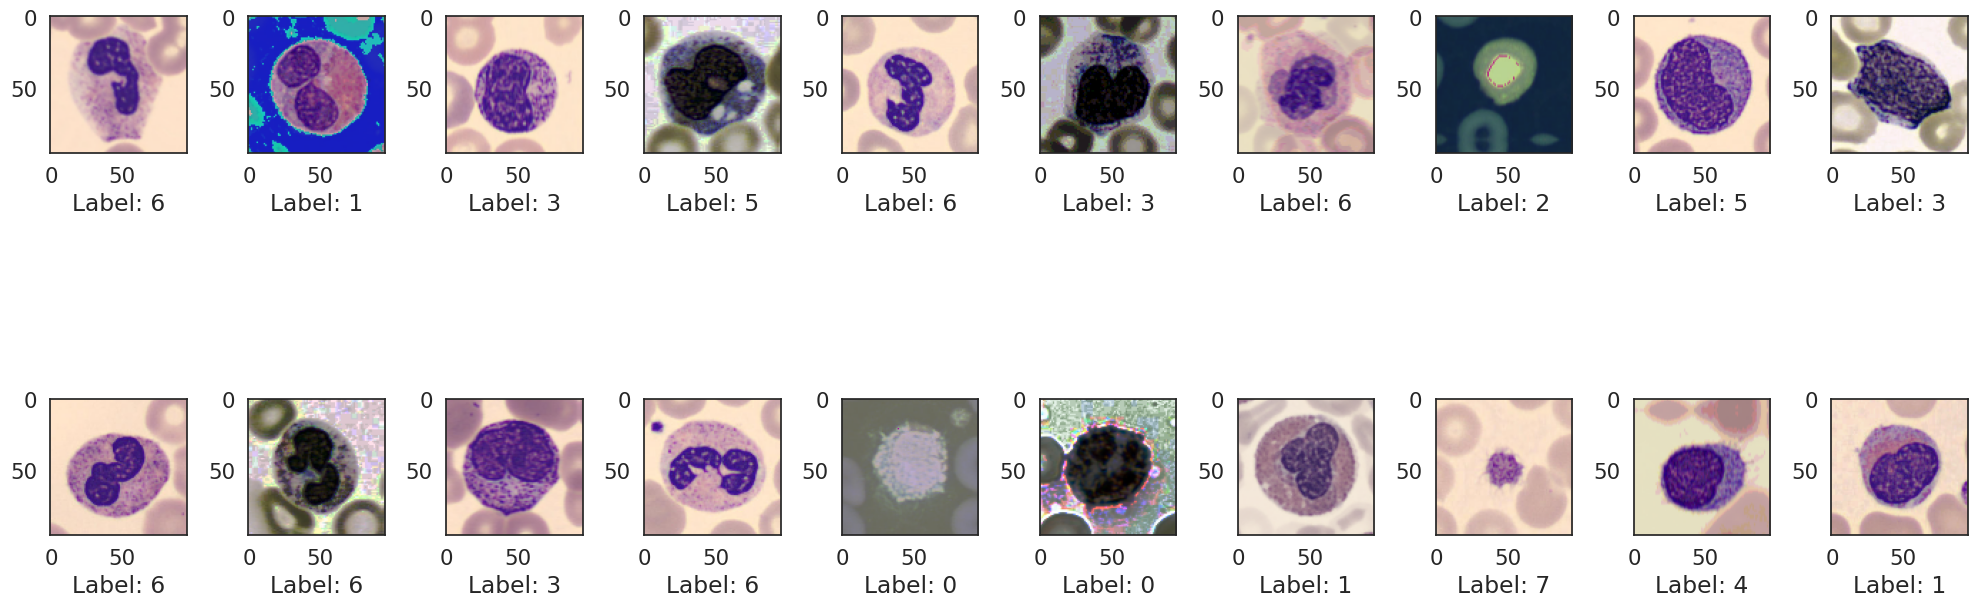

In [ ]:
# Number of random images to display
num_img = 20

# Select `num_img` random indices from the dataset without replacement
random_indices = np.random.choice(len(images), num_img, replace=False)

# Print the indices of the randomly selected images
print("Índices de las imágenes mostradas:", random_indices)

# Create a grid of subplots for displaying the selected images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))  # 2 rows and `num_img // 2` columns

# Loop through the randomly selected indices and display the corresponding images
for i, idx in enumerate(random_indices):
    # Determine the subplot position based on the current index
    ax = axes[i // (num_img // 2), i % (num_img // 2)]
    
    # Display the image, ensuring pixel values are within the range [0, 255]
    ax.imshow(np.clip(images[idx], 0, 255).astype(np.uint8))
    
    # Set the label of the image as the x-axis label
    ax.set_xlabel(f"Label: {labels[idx]}")
    
    # Enable the axis display for better visualization
    ax.axis('on')

# Adjust the layout for better spacing between subplots
plt.tight_layout()

# Display the grid of images
plt.show()


## 🧮 Define Network Parameters

In [11]:
# Number of training epochs
epochs = 1000

# Batch size for training
batch_size = 16

# Learning rate: step size for updating the model's weights
learning_rate = 0.00005

## 🛠️ Define the Model

In [ ]:
def build_model(
    input_shape=(96, 96, 3),  # Input shape for image data
    output_shape=8,  # Number of output classes
    learning_rate=learning_rate,  # Initial learning rate
):
    tf.random.set_seed(42)  # Set seed for reproducibility

    # Load EfficientNetV2S pretrained on ImageNet
    base_model = tf.keras.applications.EfficientNetV2S(
        include_top=False,  # Exclude the top layer for custom fine-tuning
        weights="imagenet",  # Use pretrained weights
        input_shape=input_shape,  # Input dimensions
    )

    # Freeze the first 50% of layers and unfreeze the rest for fine-tuning
    for layer in base_model.layers[:int(len(base_model.layers) * 0.5)]:
        layer.trainable = False
    for layer in base_model.layers[int(len(base_model.layers) * 0.5):]:
        layer.trainable = True

    # Define input layer and apply data augmentation
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    data_augmentation = tf.keras.Sequential([
        tfkl.RandomFlip('horizontal'),  # Randomly flip images horizontally
        tfkl.RandomRotation(0.1),  # Apply small random rotations
        tfkl.RandomZoom(0.1),  # Randomly zoom in/out
        tfkl.RandomContrast(0.1),  # Adjust image contrast
        tfkl.GaussianNoise(0.05),  # Add Gaussian noise
    ], name='data_augmentation')

    # Pass data through augmentation and base model
    x = data_augmentation(input_layer)
    x = base_model(x, training=True)

    # Add fully connected layers with global pooling and dropout
    x = tfkl.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = tfkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense_1')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4), name='dense_2')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.4)(x)
    x = tfkl.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(x)
    output_layer = tfkl.Dense(output_shape, activation='softmax', name='Output')(x)

    # Create the final model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='EfficientNetB7FineTuningModel')

    # Compile the model with AdamW optimizer and categorical crossentropy loss
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)  # Apply label smoothing
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)  # Use AdamW optimizer
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary()


I0000 00:00:1732442991.157763 1079927 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732442991.200449 1079927 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732442991.200546 1079927 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732442991.204332 1079927 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732442991.204387 1079927 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "EfficientNetB7FineTuningModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 3, 3, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,155,560 (80.70 MB)

 Trainable params: 16,510,336 (62.98 MB)

 Non-trainable params: 4,645,224 (17.72 MB)

## 🧠 Train the Model

In [ ]:
# Define the patience value for the EarlyStopping callback
patience = 15  # Number of epochs with no improvement before stopping

# Create an EarlyStopping callback to halt training early if no progress is made
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',       # Monitor validation accuracy for improvement
    mode='max',                   # Stop when the monitored metric stops increasing
    patience=patience,            # Number of epochs to wait without improvement
    restore_best_weights=True     # Restore the model's weights from the best epoch
)

# Store the EarlyStopping callback in a list
callbacks = [early_stopping]

# Define a learning rate scheduler to reduce the learning rate when validation loss plateaus
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss for improvement
    factor=0.2,                   # Reduce the learning rate by multiplying it by 0.2
    patience=8,                   # Number of epochs to wait before reducing the learning rate
    min_lr=1e-7                   # Set a minimum learning rate to avoid overly small values
)

# Add the learning rate scheduler to the existing callbacks
callbacks.append(lr_scheduler)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to handle class imbalance in the dataset
class_weights = compute_class_weight(
    class_weight='balanced',      # Balance weights inversely proportional to class frequencies
    classes=np.unique(labels),    # List of unique class labels
    y=labels                      # True labels for the dataset
)
class_weights = dict(enumerate(class_weights))  # Convert weights to a dictionary format

# Train the model with the computed class weights
history = model.fit(
    x=X_train,                    # Training features
    y=y_train,                    # Training labels
    batch_size=batch_size,        # Batch size for training
    epochs=epochs,                # Total number of training epochs
    validation_data=(X_test, y_test),  # Validation dataset
    callbacks=callbacks,          # Include early stopping and learning rate scheduler
    class_weight=class_weights    # Use computed class weights to handle imbalance
)

# Calculate and display the final validation accuracy
final_val_accuracy = round(max(history.history['val_accuracy']) * 100, 2)  # Find the best validation accuracy
print(f'Final validation accuracy: {final_val_accuracy}%')  # Print the final validation accuracy

# Save the trained model to a file
model_filename = 'weights.keras'  # Specify the filename
model.save(model_filename)        # Save the model in Keras format

# Delete the model from memory to free up resources
del model


Epoch 1/1000


W0000 00:00:1732443036.004520 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.024364 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.028122 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.037556 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.038729 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.039940 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.070518 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.071123 1080124 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443036.071831 1080124 gp

2092/2093 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3861 - loss: 2.0093

W0000 00:00:1732443332.031573 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.032616 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.032998 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.033343 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.033689 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.034026 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.034421 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.034789 1080142 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443332.035471 1080142 gp

2093/2093 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3862 - loss: 2.0091

W0000 00:00:1732443355.505489 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.506010 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.506351 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.506799 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.507114 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.507433 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.507856 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.508198 1080122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732443355.508556 1080122 gp

2093/2093 ━━━━━━━━━━━━━━━━━━━━ 358s 153ms/step - accuracy: 0.3863 - loss: 2.0089 - val_accuracy: 0.8657 - val_loss: 0.9386 - learning_rate: 5.0000e-05
Epoch 2/1000
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 292s 139ms/step - accuracy: 0.7964 - loss: 1.0974 - val_accuracy: 0.9143 - val_loss: 0.8177 - learning_rate: 5.0000e-05
Epoch 3/1000
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 290s 139ms/step - accuracy: 0.8621 - loss: 0.9427 - val_accuracy: 0.9371 - val_loss: 0.7523 - learning_rate: 5.0000e-05
Epoch 4/1000
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 286s 137ms/step - accuracy: 0.8952 - loss: 0.8592 - val_accuracy: 0.9491 - val_loss: 0.7247 - learning_rate: 5.0000e-05
Epoch 5/1000
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 288s 138ms/step - accuracy: 0.9206 - loss: 0.8000 - val_accuracy: 0.9576 - val_loss: 0.6945 - learning_rate: 5.0000e-05
Epoch 6/1000
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 293s 140ms/step - accuracy: 0.9329 - loss: 0.7654 - val_accuracy: 0.9635 - val_loss: 0.6862 - learning_rate: 5.0000e-05
Epoch 7/1000
2093/2093 ━━━━━━

## Plot

99.64
99.04


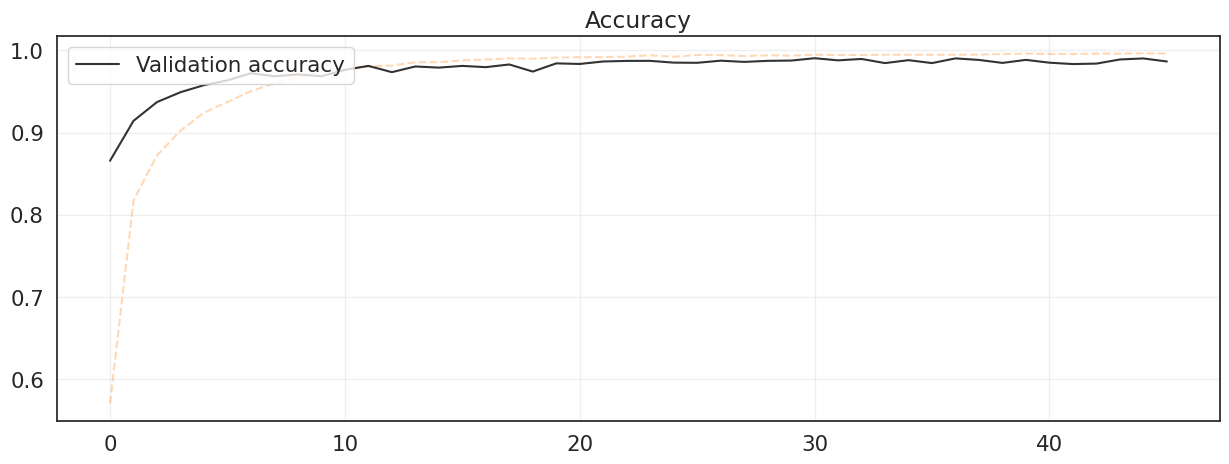

In [ ]:
# Set the figure size for the accuracy plot
plt.figure(figsize=(15, 5))

# Plot the training accuracy with semi-transparent orange dashed lines
plt.plot(
    history.history['accuracy'],  # Training accuracy history
    alpha=0.3,                    # Set transparency
    color='#ff7f0e',              # Use orange color
    linestyle='--'                # Dashed line style
)

# Plot the validation accuracy with solid black lines
plt.plot(
    history.history['val_accuracy'],  # Validation accuracy history
    label='Validation accuracy',     # Label for the validation accuracy plot
    alpha=0.8,                        # Higher opacity for visibility
    color='#000000'                   # Use black color
)

# Add a legend in the upper left corner
plt.legend(loc='upper left')

# Add a title to the plot
plt.title('Accuracy')

# Add a grid to the plot with light transparency
plt.grid(alpha=0.3)

# Print the maximum training accuracy achieved during training
print(round(max(history.history['accuracy']) * 100, 2))

# Print the maximum validation accuracy achieved during training
print(round(max(history.history['val_accuracy']) * 100, 2))

# Display the plot
plt.show()


In [ ]:
model_path = "weights.keras"
model = tfk.models.load_model(model_path)

# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

W0000 00:00:1732456450.071008 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.072905 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.073678 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.074690 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.075286 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.078087 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.079341 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.080773 1080153 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732456450.081649 1080153 gp

Predictions Shape: (14351, 8)


In [21]:
# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

Accuracy score over the test set: 0.9904
Precision score over the test set: 0.9904
Recall score over the test set: 0.9904
F1 score over the test set: 0.9904


## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [22]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X =  tfk.applications.efficientnet.preprocess_input(X)
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [23]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

  adding: model.py (deflated 54%)
  adding: weights.keras (deflated 8%)
